### NPPC signature

In [2]:
# %load startup_script.py
# system
from pprint import pprint as pp

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats

# plotting
from matplotlib import pyplot as plt
import matplotlib
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook
from bokeh.models import (
    ColumnDataSource,
    HoverTool,
    LinearColorMapper,
    BasicTicker,
    PrintfTickFormatter,
    ColorBar,
)
from bokeh.plotting import figure
import seaborn as sns
from colour import Color

# machine learning
from sklearn import linear_model

# my own module in the same repo
import helper

# jupyte notebook amenities
output_notebook()
%matplotlib inline
%autosave 30

/Users/Molly/anaconda3/lib/python3.6/site-packages/bokeh/util/deprecation.py:34: BokehDeprecationWarning: 
The bokeh.charts API has moved to a separate 'bkcharts' package.

This compatibility shim will remain until Bokeh 1.0 is released.
After that, if you want to use this API you will have to install
the bkcharts package explicitly.

  warn(message)


Loading BokehJS ...

Autosaving every 30 seconds


In [3]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
WCDT_clinical = "./data/NEPC/cleaned_up_pathology_calls.tsv"
df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")

In [4]:
def extract_label(df_clinical):
    # small cell vs adeno
    y_df = df_clinical[["Patient ID", "PURE SMALL CELL VS. ADENO (EXCLUDE IAC)",]].copy()
    y_df.rename(columns={"PURE SMALL CELL VS. ADENO (EXCLUDE IAC)":"NEPC_label", 
                         "Patient ID": "Patient_ID"}, inplace=True)
    y_df = y_df[~y_df["NEPC_label"].isin(["EXCLUDE", "NOT ADENOCARCINOMA"])].copy()
    
    y_df.set_index("Patient_ID", inplace=True)
    y_df[y_df["NEPC_label"].isin(["SMALL CELL"])] = "small cell"
    y_df[y_df["NEPC_label"].isin(["Adenocarcinoma".upper()])] = "adeno"
    return y_df


def data_prep(x=df_mRNA, y=df_clinical, group1=["small cell"], group0=["adeno"]):
    """ 
    extract the samples in label group zero v.s. label group one, 
    in training, the former is assigned a label of 0 and the latter is asigned a label of 1
    """
    # extract desired groups from y
    y = extract_label(df_clinical)
    y[y["NEPC_label"].isin(group1)] = 1
    y[y["NEPC_label"].isin(group0)] = 0
    y = y[y["NEPC_label"].isin([0, 1])]

    # get sample overlap between mRNA and y
    X = df_mRNA.set_index("gene_id").transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    return X, y


def calc_signature(X, y, classifier=linear_model.LogisticRegression()):
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    return classifier.coef_[0]


In [5]:
X, y = data_prep()

In [22]:
df = X.copy()
df["SCNC_label"] = y

In [23]:
df = df[["SCNC_label"] + list(df.columns[:-1])]

In [26]:
df.index.name="sample_id"
df.shape

(60, 58582)

### Train 50, 20k and all gene signatures

In [50]:
X, y = data_prep()
sig_df = pd.DataFrame(index=X.columns)

classifiers = {"50": linear_model.SGDClassifier(loss="log", penalty="elasticnet", alpha=1.169, 
                                                n_iter=10, random_state=0),
               "20k": linear_model.SGDClassifier(loss="log", penalty="elasticnet", alpha=0.086, 
                                                 n_iter=20, random_state=0),
               "45k": linear_model.LogisticRegression(penalty="l2")}

for sig_type, classifier in classifiers.items():
    sig_df[sig_type] = calc_signature(X, y, classifier=classifier)
    print("number of genes with none zero coefficient: ", len(sig_df[sig_df[sig_type] != 0]))


assert(np.all(list(sig_df.index) == X.columns))
sig_df.to_pickle("./data/NEPC/NEPC_sigs.pkl")

number of genes with none zero coefficient:  50
number of genes with none zero coefficient:  20309
number of genes with none zero coefficient:  44846


### LPOCV

In [9]:
# leave pair out cross validation aucs of 50 gene signature trained by logistic elasticnet
X, y = data_prep()
print(helper.leave_pair_out_cv(X, y, classifiers["50"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8555900621118012


In [1]:
X

NameError: name 'X' is not defined

In [185]:
# leave pair out cross validation aucs of 20k gene signature trained by logistic elasticnet
X, y = data_prep()
print(helper.leave_pair_out_cv(X, y, classifiers["20k"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8649068322981367


In [274]:
X, y = data_prep()
print(helper.leave_pair_out_cv(X, y, classifiers["45k"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.9021739130434783


### Apply Signature Scores to WCDT sample

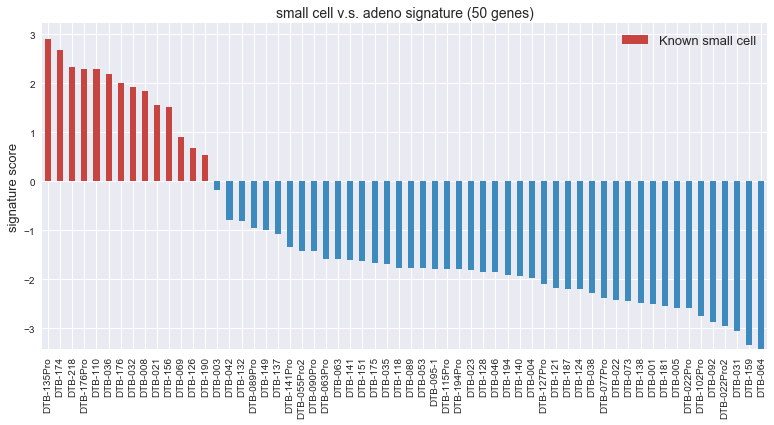

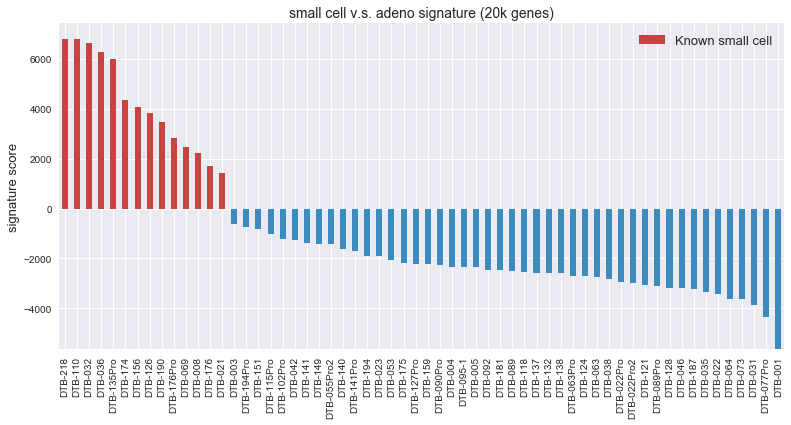

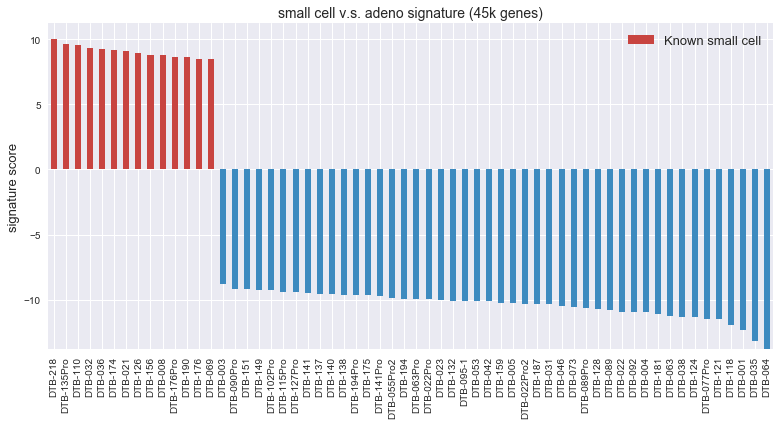

In [134]:
# apply NEPC signatures to known samples
X, y = data_prep()
sig_df = pd.read_pickle("./data/NEPC/NEPC_sigs.pkl")
sig_scores_df = pd.DataFrame(data=np.matmul(X, sig_df), index=X.index, columns=sig_df.columns) 

for sig in sig_scores_df.columns:
    sig_scores_df.sort_values(sig, ascending=False, inplace=True)
    small_cell = list(y[y["NEPC_label"] == 1].index)
    adeno = list(y[y["NEPC_label"] != 1].index)
    colors = dict(zip(small_cell + adeno, ["#C84440"] * len(small_cell) + ["#3D8ABF"] * len(adeno)))
    fig, ax= plt.subplots()
    fig.set_size_inches(13,6)
    sig_scores_df[sig].plot.bar(color=[colors[i] for i in sig_scores_df.index], ax=ax)
    ax.set_ylabel("signature score", fontsize=13)
    ax.legend(["Known small cell"], fontsize=13)
    ax.set_title("small cell v.s. adeno signature ({0} genes)".format(sig), fontsize=14)
    fig.savefig("./{0}_gene_scores.png".format(sig), dpi=200)

### Heatmap with 50 gene signature with WCDT sample

In [135]:
def median_centering(df):
    """ gene-wise median centering """
    medians = df.median(axis=1)
    for i in df.index:
        df.loc[i] = df.loc[i] - medians[i]
    return df

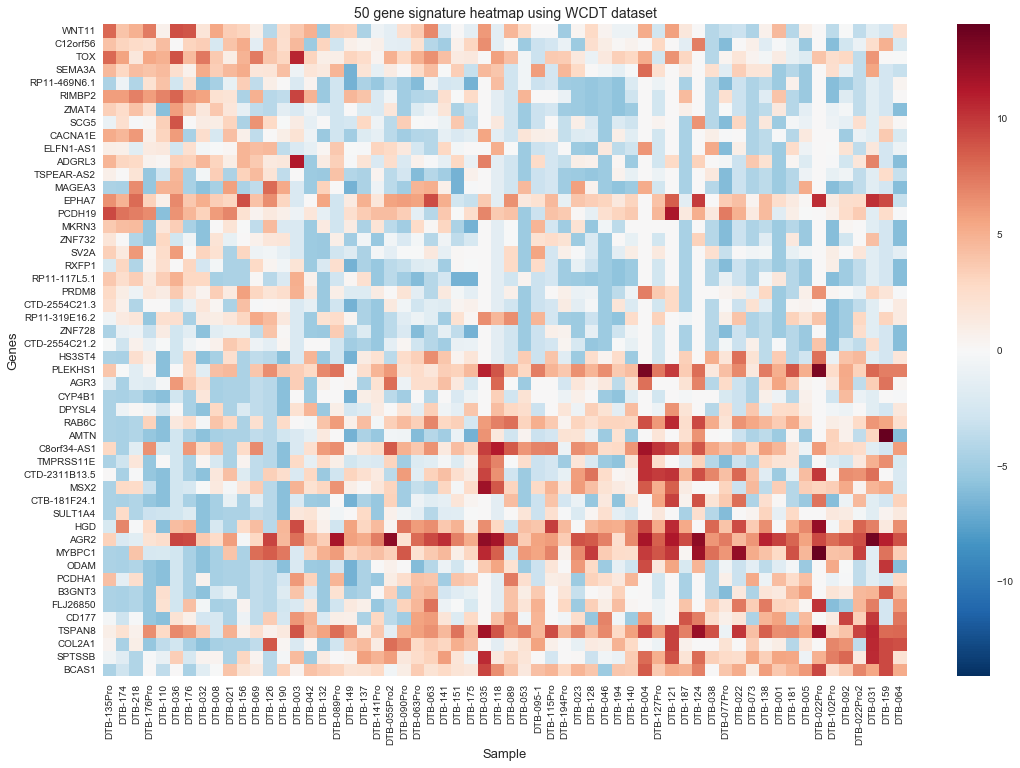

In [136]:
X50 = median_centering(X[sig_df[sig_df["50"]!=0].index].copy())

# order samples by their score
sig_scores_df50 = sig_scores_df[sig_scores_df["50"]!=0].copy()
sample_order = list(sig_scores_df50.sort_values("50", ascending=False).index)
X50 = X50.loc[sample_order]

# order genes by their absolute coefficient
gene_order = sig_df[sig_df["50"]!=0].sort_values("50", ascending=False).index
X50 = X50[gene_order]
X50 = X50.transpose()

fig, ax = plt.subplots()
fig.set_size_inches(18, 12)
sns.heatmap(X50, ax=ax, center=0)
ax.set_ylabel("Genes", fontsize=13)
ax.set_xlabel("Sample", fontsize=13)
fig.savefig("./heatmap.png", dpi=300)
ax.set_title("50 gene signature heatmap using WCDT dataset", fontsize=14)
plt.show()

### Apply Signature Scores to Beltran and ECDT sample

In [235]:
def process_data(X, df):
    # drop duplicate genes
    new_X, new_df = X.T, df.T
    new_X = new_X[~new_X.index.duplicated(keep="first")].T
    new_df = new_df[~new_df.index.duplicated(keep="first")].T
    common_genes = sorted(list(set(new_X.columns).intersection(new_df.columns)))
    return new_X[common_genes], new_df[common_genes]


def save_signature(X, y, dataset, classifiers):
    sig_df = pd.DataFrame(index=X.columns)
    for sig_type, classifier in classifiers.items():
        sig_df[sig_type] = calc_signature(X, y, classifier=classifier)
        print("number of genes with none zero coefficient: ", len(sig_df[sig_df[sig_type] != 0]))

    assert(np.all(list(sig_df.index) == X.columns))
    sig_df.to_pickle("./data/NEPC/NEPC_{0}_sigs.pkl".format(dataset))
    
    
def apply_signature(sig_df, target_df, dataset, figsize=(13,6)):
    sig_scores_df = pd.DataFrame(data=np.matmul(target_df, sig_df), 
                                 index=target_df.index, columns=sig_df.columns) 
    for sig in sig_scores_df.columns:
        sig_scores_df.sort_values(sig, ascending=False, inplace=True)
        fig, ax= plt.subplots()
        fig.set_size_inches(figsize)
        sig_scores_df[sig].plot.bar(color="#3D8ABF", ax=ax)
        ax.set_ylabel("signature score", fontsize=13)
        ax.set_title("small cell v.s. adeno signature ({0} genes), {1} samples".format(sig, dataset), fontsize=14)
        fig.savefig("./{0}_gene_scores_{1}.png".format(sig, dataset), dpi=200)
    return sig_scores_df
    

def plot_heat_map(sig_df, sig_scores_df, target_df, dataset):
    X50 = median_centering(target_df[sig_df[sig_df["50"]!=0].index].copy())
    print(X50.shape)
    
    # # order samples by their score
    sig_scores_df50 = sig_scores_df[sig_scores_df["50"]!=0].copy()
    sample_order = list(sig_scores_df50.sort_values("50", ascending=False).index)
    X50 = X50.loc[sample_order]

    # order genes by their absolute coefficient
    gene_order = sig_df[sig_df["50"]!=0].sort_values("50", ascending=False).index
    X50 = X50[gene_order]
    X50 = X50.transpose()

    fig, ax = plt.subplots()
    fig.set_size_inches(18.0 * target_df.shape[0]/60, 12)
    sns.heatmap(X50, ax=ax, center=0)
    ax.set_ylabel("Genes", fontsize=13)
    ax.set_xlabel("Sample", fontsize=13)
    fig.savefig("./heatmap_{0}.png".format(dataset), dpi=100)
    ax.set_title("50 gene signature heatmap using {0} dataset".format(dataset), fontsize=14)

In [117]:
classifiers = {"50": linear_model.SGDClassifier(loss="log", penalty="elasticnet", alpha=0.93, 
                                                n_iter=10, random_state=0),
                "18k": linear_model.LogisticRegression(penalty="l2")}
df_beltran = pd.read_csv("./data/Beltran_mRNA.tsv", sep="\t", index_col="Gene")
df_beltran.index.name = "gene_id"
X, y = data_prep()
X_WCDT, X_beltran = process_data(X, df_beltran.T)
save_signature(X_WCDT, y, "beltran", classifiers)

number of genes with none zero coefficient:  50
number of genes with none zero coefficient:  17622


In [118]:
# leave pair out cross validation aucs of 50 gene signature trained by logistic elasticnet
print(helper.leave_pair_out_cv(X_WCDT, y, classifiers["50"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8586956521739131


In [119]:
# leave pair out cross validation aucs of 50 gene signature trained by logistic elasticnet
print(helper.leave_pair_out_cv(X_WCDT, y, classifiers["18k"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.9114906832298136


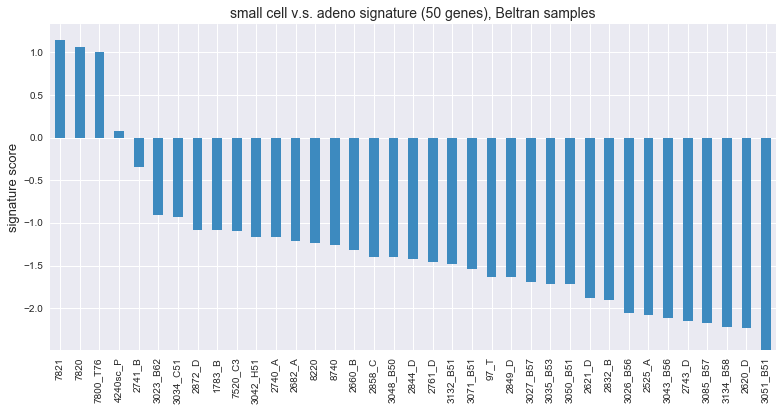

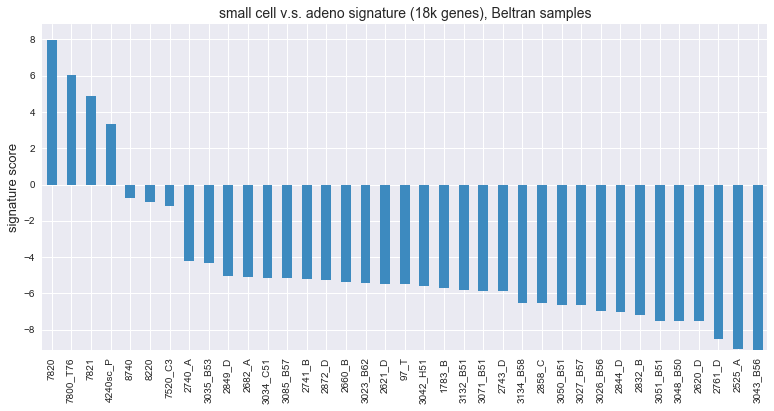

In [122]:
# apply NEPC signatures to beltran samples
sig_df = pd.read_pickle("./data/NEPC/NEPC_beltran_sigs.pkl")
sig_scores_df = apply_signature(sig_df, X_beltran, "Beltran")

(37, 50)


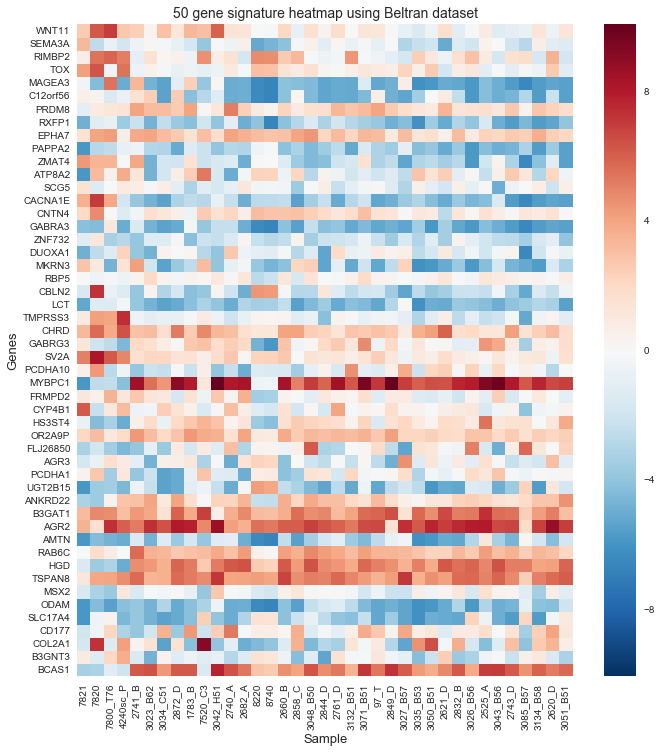

In [133]:
sig_df = pd.read_pickle("./data/NEPC/NEPC_beltran_sigs.pkl")
plot_heat_map(sig_df, sig_scores_df, X_beltran, "Beltran")

In [230]:
classifiers = {"50": linear_model.SGDClassifier(loss="log", penalty="elasticnet", alpha=0.941, 
                                                n_iter=10, random_state=0),
                "22k": linear_model.LogisticRegression(penalty="l2")}
df_ECDT = pd.read_csv("./data/ECDT_mRNA.tsv", sep="\t", index_col="Hugo_Symbol")
df_ECDT.index.name = "gene_id"
df_ECDT = df_ECDT.applymap(lambda x: np.log(x+1))
X, y = data_prep()
X_WCDT, X_ECDT = process_data(X, df_ECDT.T)
save_signature(X_WCDT, y, "ECDT", classifiers)

number of genes with none zero coefficient:  50
number of genes with none zero coefficient:  22225


In [231]:
# leave pair out cross validation aucs of 50 gene signature trained by logistic elasticnet
print(helper.leave_pair_out_cv(X_WCDT, y, classifiers["50"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8493788819875776


In [232]:
# leave pair out cross validation aucs of 50 gene signature trained by logistic elasticnet
print(helper.leave_pair_out_cv(X_WCDT, y, classifiers["22k"]))

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8975155279503105


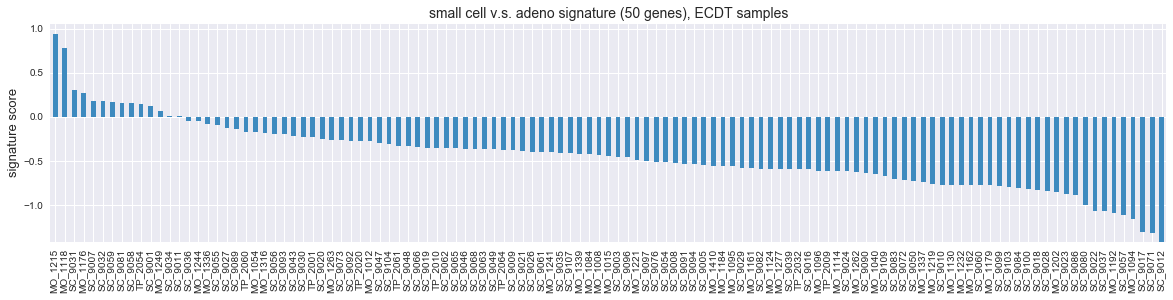

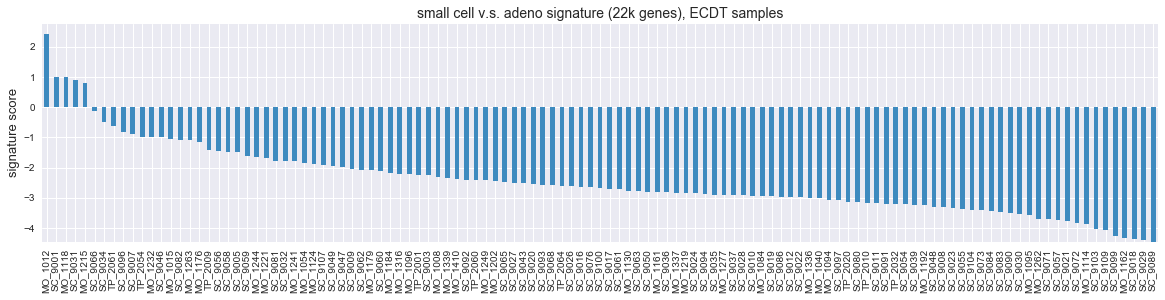

In [233]:
sig_df = pd.read_pickle("./data/NEPC/NEPC_ECDT_sigs.pkl")
sig_scores_df = apply_signature(sig_df, X_ECDT, "ECDT", figsize=(20, 4))

(117, 50)


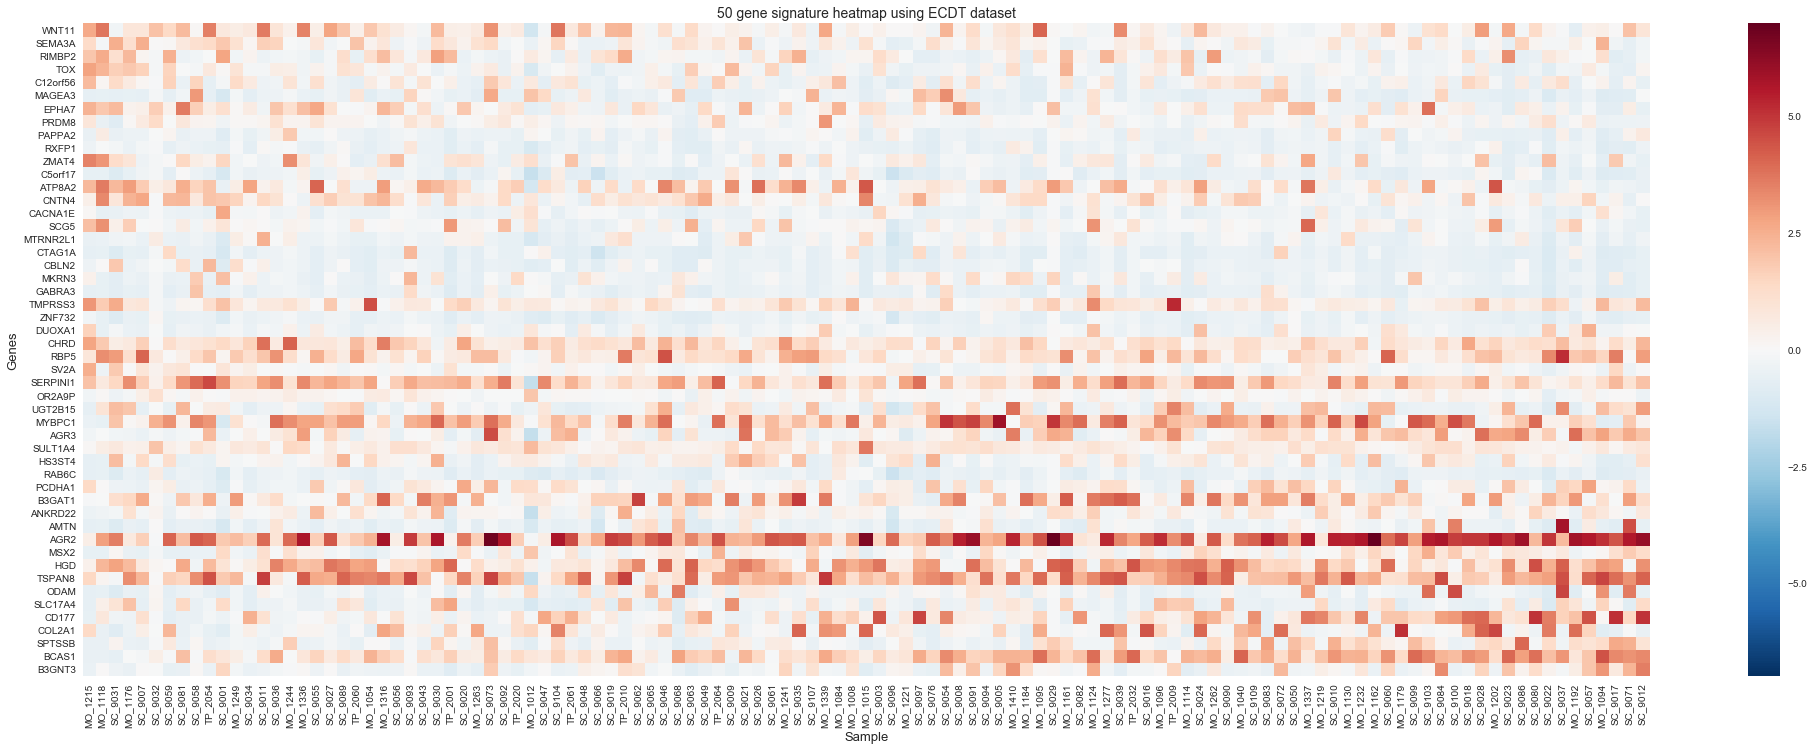

In [236]:
plot_heat_map(sig_df, sig_scores_df, X_ECDT, "ECDT")

### Make change to one plot based on Joshi's request (June-9-2017)

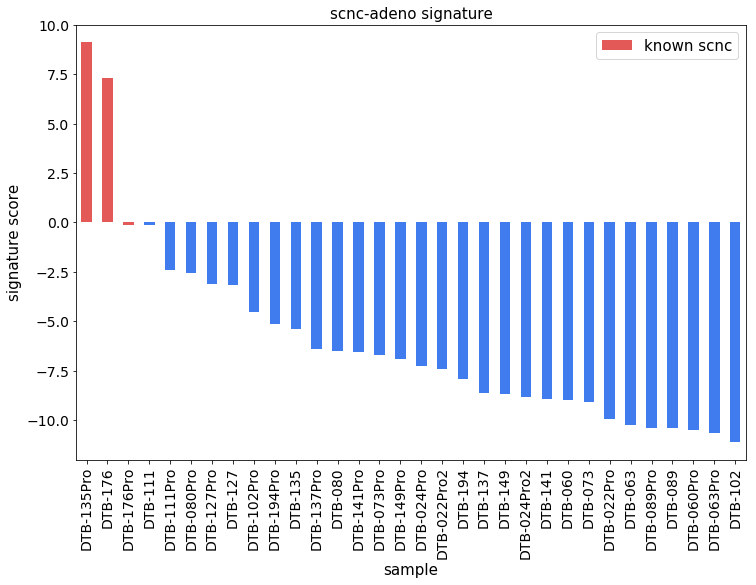

In [100]:
### add "DTB-176Pro" to scnc label

plt.figure(figsize=(9,5))
this_sig = df_combined[["scnc-adeno", "TimePoint", "NEPC_label"]].copy().sort_values(by="scnc-adeno", ascending=False)
this_sig.set_value("DTB-176Pro", "NEPC_label", "scnc") ####### Here is the real change

highlight = list(this_sig[this_sig["NEPC_label"] == "scnc"].index)
rest = list(this_sig[this_sig["NEPC_label"] != "scnc"].index)
colors = dict(zip(highlight + rest, ["#E35957"] * len(highlight) + ["#407CED"] * len(rest)))

this_sig["scnc-adeno"].plot.bar(color=[colors[i] for i in this_sig.index], figsize=(12,8), fontsize=14)

plt.title("scnc-adeno" + " signature", fontsize=15)
plt.ylabel("signature score", fontsize=15)
plt.ylim((-12,10))
plt.xlabel("sample", fontsize=15)
plt.legend(["known " + "scnc"], fontsize=15)

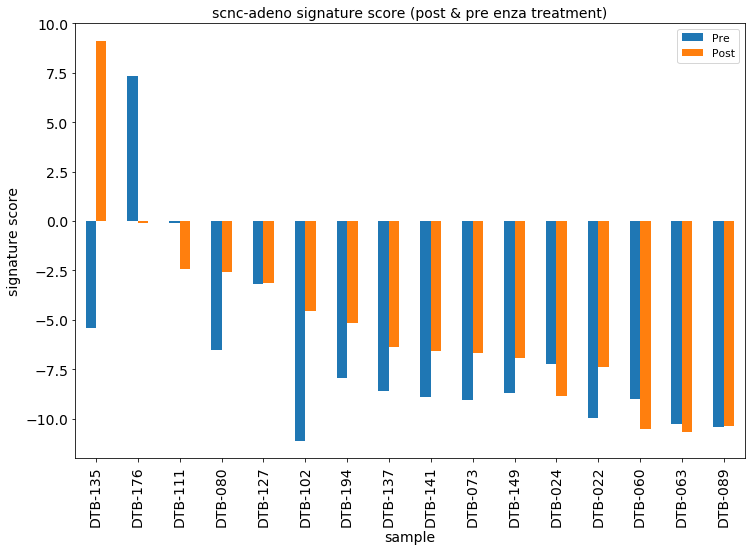

In [99]:
### plot same graph with sample post-pre values side by side
def extract_sample_name(name):
    if name.endswith("Pro"):
        return name[:-3]
    elif name.endswith("Pro2"):
        return name[:-4]
    else:
        assert(name[-1] in "0123456789")
        return name

sample_pair = pd.read_csv("./data/WCDT_paired_samples.tab", delimiter="\t", index_col="Sample")
assert(sorted(list(sample_pair.index))==sorted(list(this_sig.index)))
sample_pair_dict = dict(zip(sample_pair.index, sample_pair['TimePoint']))
this_sig_pair = pd.DataFrame(columns=["Pre", "Post"])
for index, row in this_sig.iterrows():
    sample_name = extract_sample_name(index)
    sample_type = sample_pair_dict[index]
    this_sig_pair.set_value(sample_name, sample_type, row["scnc-adeno"])

this_sig_pair.plot.bar(figsize=(12,8), fontsize=14)
plt.title("scnc-adeno signature score (post & pre enza treatment)", fontsize=14)
plt.ylabel("signature score", fontsize=14)
plt.ylim((-12,10))
plt.xlabel("sample", fontsize=14)